In [0]:
import tensorflow as tf
from IPython.display import Image
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data


In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
def one_hot(x, zero_index=True):
    if zero_index:
        return np.eye(max(x)+1)[x]
    else:
        return np.eye(max(x))[x]
def normalize(x):
    return (x.astype(np.float32) - 127.5)/127.5

In [0]:
X_train = normalize(X_train)
X_test = normalize(X_test)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [118]:
Y_train = one_hot(Y_train)
Y_test = one_hot(Y_test)
# X_train = X_train.reshape((-1, 784))
# X_test = X_test.reshape((-1, 784))
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [0]:
def smooth_hinge_loss(logits, labels, t=1e-3, dty=tf.float64):
    margin=tf.multiply(tf.cast(labels, dtype=dty), logits) 
    exponents = (1-margin)/t
    max_elems = tf.maximum(exponents, tf.zeros_like(exponents))
    log_loss= t * (max_elems + tf.log(tf.exp(exponents - max_elems) 
                                      + tf.exp(tf.zeros_like(exponents) - max_elems)))
    return tf.reduce_mean(log_loss) 




def hinge_loss(logits, labels, dty=tf.float64):
    margin=tf.multiply(tf.cast(labels, dtype=dty), logits) 
    log_loss= tf.maximum(tf.constant(0,dtype=dty), 1-margin)
    return tf.reduce_mean(log_loss) 


def accuracy_op(logits, labels):
    correct_prediction = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), tf.cast(tf.argmax(labels, 1), tf.int32))
    accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.int32))
    return accuracy

def hessian_vector_product(ys, xs, v):
    # Validate the input
    length = len(xs)
    if len(v) != length:
      raise ValueError("xs and v must have the same length.")

    # First backprop
    grads = tf.gradients(ys, xs)

    # grads = xs

    assert len(grads) == length

    elemwise_products = [
        math_ops.multiply(grad_elem, array_ops.stop_gradient(v_elem))
        for grad_elem, v_elem in zip(grads, v) if grad_elem is not None
    ]

    # Second backprop  
    grads_with_none = tf.gradients(elemwise_products, xs)
    return_grads = [
        grad_elem if grad_elem is not None \
        else tf.zeros_like(x) \
        for x, grad_elem in zip(xs, grads_with_none)]
    
    return return_grads

In [0]:
def conv2d(x, W, r):
    # convolve through reflect padding
    p = (W.shape[0] - 1) // 2
    x = tf.pad(x, [[0,0],[p,p],[p,p],[0,0]], 'REFLECT')
    return tf.nn.conv2d(x, W, strides=[1, r, r, 1], padding='VALID')

In [0]:
def log_softmax_CE(L, y):
    # calculate loss for the loss function and L2 regularizer
    L_max = tf.reduce_max(L, axis = 1, keepdims = True)
    L = L-L_max
    # compute log softmax
    A = tf.log(tf.reduce_sum(tf.exp(L), axis = 1))
    B = tf.reduce_sum(L*y, axis=1)
    loss = tf.reduce_sum(A-B)
    return loss

In [0]:
def hessians(ys, xs, name="hessians", colocate_gradients_with_ops=False, 
            gate_gradients=False, aggregation_method=None):
  def _AsList(x):
      return x if isinstance(x, (list, tuple)) else [x]

  xs = _AsList(xs)
  kwargs = {
      'colocate_gradients_with_ops': colocate_gradients_with_ops,
      'gate_gradients': gate_gradients,
      'aggregation_method': aggregation_method
    }
  # Compute a hessian matrix for each x in xs
  hessians = []
  for i, x in enumerate(xs):
    # Check dimensions
    ndims = x.get_shape().ndims
    if ndims is None:
      raise ValueError('Cannot compute Hessian because the dimensionality of '
                       'element number %d of `xs` cannot be determined' % i)
    elif ndims != 1:
      raise ValueError('Computing hessians is currently only supported for '
                       'one-dimensional tensors. Element number %d of `xs` has '
                       '%d dimensions.' % (i, ndims))
    with ops.name_scope(name + '_first_derivative'):
      # Compute the partial derivatives of the input with respect to all 
      # elements of `x`
      _gradients = tf.gradients(ys, x, **kwargs)[0]
      # Unpack the gradients into a list so we can take derivatives with 
      # respect to each element
      _gradients = array_ops.unpack(_gradients, num=10240)
    with ops.name_scope(name + '_second_derivative'):
      # Compute the partial derivatives with respect to each element of the list
      _hess = [tf.gradients(_gradient, x, **kwargs)[0] for _gradient in _gradients]
      # Pack the list into a matrix and add to the list of hessians
      hessians.append(array_ops.pack(_hess, name=name))
  return hessians

## Tensorflow hessian (tf.hessian) is not a exact hessians

In [0]:
tf.reset_default_graph()
nb_clases=10
dty=tf.float32
scale_hess=1e0
damping=1e-2
batch=len(X_test)//512

w1=tf.get_variable('w1', [3*3*1*64], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(3*3*1*64)), dtype=dty))
w2=tf.get_variable('w2', [3*3*64*64], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(3*3*64*64)), dtype=dty))
w3=tf.get_variable('w3', [3*3*64*64], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(3*3*64*64)), dtype=dty))
w4=tf.get_variable('w4', [4*4*64*10], initializer=tf.truncated_normal_initializer(stddev=1.0/np.math.sqrt(float(4*4*64*10)), dtype=dty))
# params=[w1, w2, w3, w4]
params=[w4]
v_cur_est = [tf.placeholder(dty, shape=(param.shape[0])) for param in params]
####################### Layer ######################
X = tf.placeholder(dty, [None, 28, 28, 1],name="X")
Y = tf.placeholder(dty,[None, nb_clases],name="Y")
L = conv2d(X, tf.reshape(w1, [3,3,1,64]), 2)
L = tf.nn.elu(L)
L = conv2d(L, tf.reshape(w2, [3,3,64,64]), 2)
L = tf.nn.elu(L)
L = conv2d(L, tf.reshape(w3, [3,3,64,64]), 2)
L = tf.nn.elu(L)
L = tf.reshape(L, [-1, 4*4*64])
L = tf.matmul(L, tf.reshape(w4, [4*4*64, 10]))
prob = tf.nn.log_softmax(L)
###################################################
####################### Loss ######################
lossL2 = damping*tf.add_n([tf.nn.l2_loss(param) for param in params])
loss = log_softmax_CE(L, Y)
total_loss = loss + lossL2
grad = tf.gradients(total_loss, params)
test_grad = tf.gradients(loss, params)
hessian_vector_val=hessian_vector_product(total_loss, params, v_cur_est)
########################  H inverse ######################## 
################################################
train_op = tf.train.AdamOptimizer(1e-2).minimize(total_loss)
accuracy=accuracy_op(L, Y)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [212]:
for epoch in range(151):
    for i in range(batch):
        batch_xs, batch_ys = X_train[i*512:(i+1)*512], Y_train[i*512:(i+1)*512]
        _=sess.run(train_op, feed_dict={X:batch_xs, Y:batch_ys})  
    if epoch%50==0 and epoch>0:
        c = sess.run(accuracy, feed_dict={X:batch_xs, Y:batch_ys})
        a = sess.run(accuracy, feed_dict={X:X_test, Y:Y_test})
        print(' Train accuracy: ',c/len(batch_xs), 'Test accuracy: ',a/len(X_test), )


 Train accuracy:  1.0 Test accuracy:  0.9701
 Train accuracy:  1.0 Test accuracy:  0.9699
 Train accuracy:  1.0 Test accuracy:  0.9703


# IHVP 

## Numpy direct IHVP

In [213]:
test_index=191
z_test=X_test[test_index].reshape((1,28,28,1))
z_test_label=Y_test[test_index].reshape((1,10))
# test_val=sess.run(grad, feed_dict={X:z_test, Y:z_test_label})
test_val=sess.run(test_grad, feed_dict={X:z_test, Y:z_test_label})
print('Norm of test gradient: %s' % np.linalg.norm(np.concatenate(test_val)))

Norm of test gradient: 0.016960125


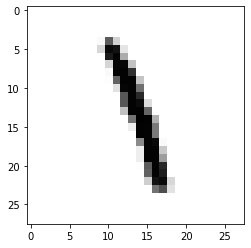

In [214]:
plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
plt.show()

## HVPs+Lissa

In [0]:
def get_inverse_hvp_lissa(sess, v, x, y, v_cur_est, hessian_vector_val, batch_size=None, 
                          scale=10, damping=0.0, recursion_depth=10000, tolerance=1e-3):
    """
    This uses mini-batching; uncomment code for the single sample case.
    """    
    inverse_hvp = None
    print_iter = recursion_depth / 10 
    cur_estimate = v
    prev = np.linalg.norm(np.concatenate(cur_estimate))
    start_time = time.time()
    for i in range(recursion_depth):
        r=np.random.choice(len(X_train), size=[batch_size],  replace=False)
        batch_xs = x[r]
        batch_ys = y[r]
        for j in range(batch_size):
            feed_dict = {place:cur for place, cur in zip(v_cur_est, cur_estimate)}
            hvp = sess.run(hessian_vector_val, feed_dict={X:batch_xs[j:j+1], Y:batch_ys[j:j+1], **feed_dict})
            cur_estimate = [a + (1-damping/scale) * b - c/scale for (a,b,c) in zip(v, cur_estimate, hvp)]    
        con=np.concatenate(cur_estimate)
        cur_norm = np.linalg.norm(con)
        if (i % print_iter ==0) or (i == recursion_depth - 1):
            print(v[0][0], hvp[0][0], cur_estimate[0][0])
            duration = time.time() - start_time
            print("Recursion at depth %s: norm is %.8lf" % (i, cur_norm))

        if inverse_hvp is None:
            inverse_hvp = [b/scale for b in cur_estimate]
        else:
            inverse_hvp = [a + b/scale for (a, b) in zip(inverse_hvp, cur_estimate)]  
        if np.abs(cur_norm - prev)<tolerance:
            print(' ## Early stopping criteria reached')
            break
        prev = cur_norm
    print('Computing Inverse HVP took %s minute %s sec' %(duration//60, duration%60))
    inverse_hvp = [a for a in inverse_hvp]
    return inverse_hvp

In [220]:
inverse_hvp = get_inverse_hvp_lissa(sess, test_val, X_train, Y_train, v_cur_est, hessian_vector_val, batch_size=2, scale=10000,  recursion_depth=500, tolerance=1e-4)

-1.4828623e-20 -2.96571e-22 -4.4485822e-20
Recursion at depth 0: norm is 0.05088032
-1.4828623e-20 -6.1580225e-09 -6.1580164e-07
Recursion at depth 50: norm is 1.74630582
-1.4828623e-20 -6.1583805e-09 -6.1583745e-07
Recursion at depth 100: norm is 3.43545747
-1.4828623e-20 -6.1670438e-09 -6.1670374e-07
Recursion at depth 150: norm is 5.09519053
-1.4828623e-20 -6.178141e-09 -6.178135e-07
Recursion at depth 200: norm is 6.78885126
-1.4828623e-20 -6.183942e-09 -6.183936e-07
Recursion at depth 250: norm is 8.48329353
-1.4828623e-20 -6.1776335e-09 -6.1776274e-07
Recursion at depth 300: norm is 10.15564823
-1.4828623e-20 -1.23220865e-08 -1.2322074e-06
Recursion at depth 350: norm is 11.82891655
-1.4828623e-20 -1.3685122e-08 -1.3685109e-06
Recursion at depth 400: norm is 13.51339340
-1.4828623e-20 -1.4764138e-08 -1.4764124e-06
Recursion at depth 450: norm is 15.20763588
-1.4828623e-20 -1.4727465e-08 -1.472745e-06
Recursion at depth 499: norm is 16.86409760
Computing Inverse HVP took 0.0 minut

## by hvp

In [221]:
one_class = True

if one_class == True:
    s=time.time()
    val_lissa=[]
    for i in range(len(X_train)):
        if np.argmax(Y_train[i])==np.argmax(Y_test[test_index]):
            z_train=X_train[i].reshape((1,28,28,1))
            z_train_label=Y_train[i].reshape((1,10))
            train_grad_loss_val=sess.run(grad, feed_dict={X:z_train, Y:z_train_label})
            val_lissa.append([i, -np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val))])
    duration = time.time() - s
    print('Multiplying by %s train examples took %s minute %s sec' % (1, duration//60, duration%60))
    val_lissa=sorted(val_lissa, key=lambda x: x[1])[::-1]
else:
    s=time.time()
    val_lissa=[]
    for i in range(len(X_train)):
        z_train=X_train[i].reshape((1,28,28,1))
        z_train_label=Y_train[i].reshape((1,10))
        train_grad_loss_val=sess.run(grad, feed_dict={X:z_train, Y:z_train_label})
        val_lissa.append([i, -np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val))])
    duration = time.time() - s
    print('Multiplying by %s train examples took %s minute %s sec' % (1, duration//60, duration%60))
    val_lissa=sorted(val_lissa, key=lambda x: x[1])[::-1]

Multiplying by 1 train examples took 0.0 minute 18.369544982910156 sec


#  Pictures

# only 1

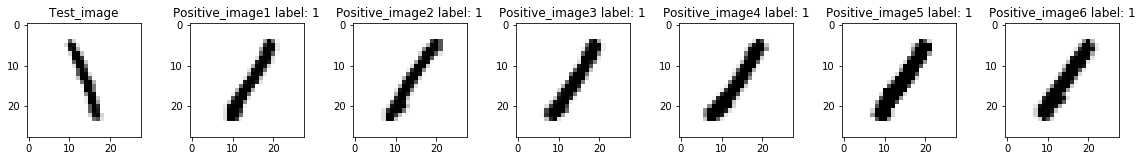

In [222]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(X_train[val_lissa[0][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image1 label: %d'  %np.argmax(Y_train[val_lissa[0][0]]))
    elif i == 3:
        plt.imshow(X_train[val_lissa[1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image2 label: %d' %np.argmax(Y_train[val_lissa[1][0]]))
    elif i == 4:
        plt.imshow(X_train[val_lissa[2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image3 label: %d'  %np.argmax(Y_train[val_lissa[2][0]]))
    elif i == 5:
        plt.imshow(X_train[val_lissa[3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image4 label: %d'  %np.argmax(Y_train[val_lissa[3][0]]))
    elif i == 6:
        plt.imshow(X_train[val_lissa[4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image5 label: %d' %np.argmax(Y_train[val_lissa[4][0]]))
    elif i == 7:
        plt.imshow(X_train[val_lissa[5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image6 label: %d'  %np.argmax(Y_train[val_lissa[5][0]]))
plt.tight_layout()
plt.show()

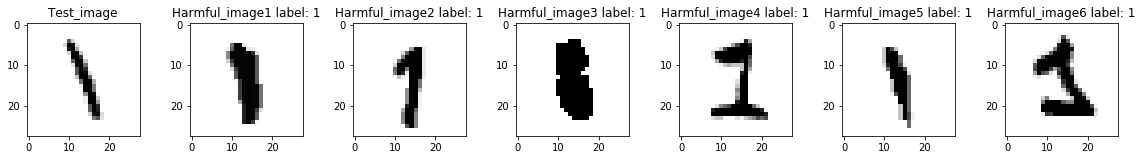

In [223]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(X_train[val_lissa[-1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image1 label: %d' %np.argmax(Y_train[val_lissa[-1][0]]))
    elif i == 3:
        plt.imshow(X_train[val_lissa[-2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image2 label: %d' %np.argmax(Y_train[val_lissa[-2][0]]))
    elif i == 4:
        plt.imshow(X_train[val_lissa[-3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image3 label: %d' %np.argmax(Y_train[val_lissa[-3][0]]))
    elif i == 5:
        plt.imshow(X_train[val_lissa[-4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image4 label: %d' %np.argmax(Y_train[val_lissa[-4][0]]))
    elif i == 6:
        plt.imshow(X_train[val_lissa[-5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image5 label: %d' %np.argmax(Y_train[val_lissa[-5][0]]))
    elif i == 7:
        plt.imshow(X_train[val_lissa[-6][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image6 label: %d' %np.argmax(Y_train[val_lissa[-6][0]]))
plt.tight_layout()
plt.show()

# various classes

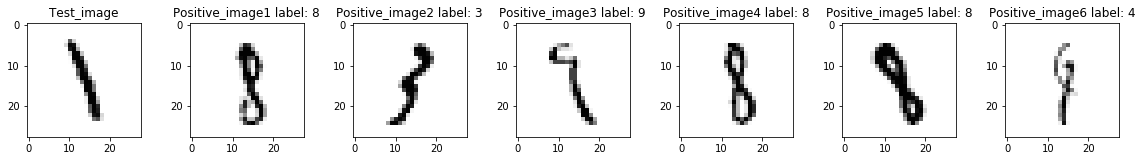

In [0]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(X_train[val_lissa[0][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image1 label: %d'  %np.argmax(Y_train[val_lissa[0][0]]))
    elif i == 3:
        plt.imshow(X_train[val_lissa[1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image2 label: %d' %np.argmax(Y_train[val_lissa[1][0]]))
    elif i == 4:
        plt.imshow(X_train[val_lissa[2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image3 label: %d'  %np.argmax(Y_train[val_lissa[2][0]]))
    elif i == 5:
        plt.imshow(X_train[val_lissa[3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image4 label: %d'  %np.argmax(Y_train[val_lissa[3][0]]))
    elif i == 6:
        plt.imshow(X_train[val_lissa[4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image5 label: %d' %np.argmax(Y_train[val_lissa[4][0]]))
    elif i == 7:
        plt.imshow(X_train[val_lissa[5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image6 label: %d'  %np.argmax(Y_train[val_lissa[5][0]]))
plt.tight_layout()
plt.show()

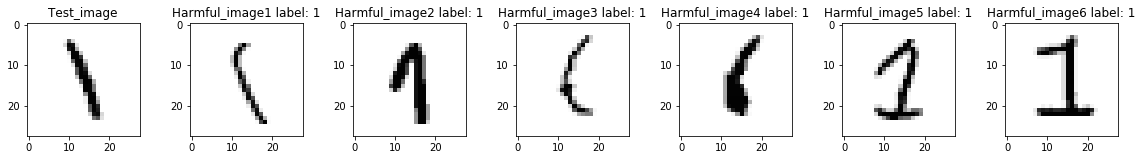

In [0]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(X_test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(X_train[val_lissa[-1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image1 label: %d' %np.argmax(Y_train[val_lissa[-1][0]]))
    elif i == 3:
        plt.imshow(X_train[val_lissa[-2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image2 label: %d' %np.argmax(Y_train[val_lissa[-2][0]]))
    elif i == 4:
        plt.imshow(X_train[val_lissa[-3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image3 label: %d' %np.argmax(Y_train[val_lissa[-3][0]]))
    elif i == 5:
        plt.imshow(X_train[val_lissa[-4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image4 label: %d' %np.argmax(Y_train[val_lissa[-4][0]]))
    elif i == 6:
        plt.imshow(X_train[val_lissa[-5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image5 label: %d' %np.argmax(Y_train[val_lissa[-5][0]]))
    elif i == 7:
        plt.imshow(X_train[val_lissa[-6][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image6 label: %d' %np.argmax(Y_train[val_lissa[-6][0]]))
plt.tight_layout()
plt.show()